<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Interpréter des conditions atypiques à l'aide d'autoencodeurs variationnels conditionnels </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

# Table de contenu

## 0. Préparation de l'environnement de travail
- chargement des modules
- mise en forme des données
- définition de quelques fonctions utiles

## 1. Premier modèle VAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations

## 2. Modèle CVAE
- construction du modèle
- entrainement
- évaluation de la représentation obtenue
- premières interprétations
- analyse spécifique jours fériés et points atypiques

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
#root git folder 
name_model="vae_test"
path_second_folder = "/home/goubetcle/Documents/Git/VAE/"
save_path = "/home/goubetcle/Documents/VAE/"
log_dir_model=save_path+"/logs/Usecase/"
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [3]:
import importlib

sys.path.append(path_second_folder+'/src')

import models, loss_class, params_class,AE_blocks,metrics
from models import *
importlib.reload(models)
from loss_class import *
importlib.reload(loss_class)
from params_class import *
importlib.reload(params_class)
import AE_blocks
importlib.reload(AE_blocks)
from callbacks import *
from metrics import *
importlib.reload(metrics)
from utils import *

%load_ext autoreload
%autoreload 2


2022-03-03 10:50:48.701465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:50:48.878602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:50:48.878910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-03 10:50:48.880657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [4]:
# Load dataframe
dataset_csv = os.path.join('data', "data_conso_2012-2021.parquet.brotli")
df_data = pd.read_parquet(dataset_csv)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

,utc_datetime,Consommation,prevision_j,prevision_j-1,prevision_neb,prevision_temp,is_holidays
157819,2020-12-31 21:30:00+00:00,64423.0,63700.0,64400.0,3.400764,2.328079,0.0
157820,2020-12-31 22:00:00+00:00,63505.0,63200.0,63800.0,3.479000,2.164250,0.0
157821,2020-12-31 22:30:00+00:00,64331.0,65200.0,65800.0,3.490986,2.029558,0.0
157822,2020-12-31 23:00:00+00:00,66853.0,67000.0,67500.0,3.369000,1.950550,0.0
157823,2020-12-31 23:30:00+00:00,66750.0,67200.0,67600.0,3.045322,1.953771,0.0


On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, tout ce qui va être inséré comme entrées du modèle est ici normalisé sur l'ensemble des mesures, puis mis en profils journaliers.

Notre jeu d'entrainement et pour référence est le jeu de données 2012-2018.

In [5]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,58315.0,58315.0,56231.0,56075.0,55532.0,54911.0,52496.0,50664.0,49161.0,47596.0,...,57333.0,57786.0,57752.0,56946.0,56054.0,54975.0,53890.0,54348.0,56577.0,55634.0
2012-01-02,55164.0,53643.0,51404.0,50842.0,50399.0,50113.0,48201.0,47182.0,46306.0,46294.0,...,73263.0,72615.0,71079.0,69050.0,67435.0,65332.0,63756.0,64030.0,65929.0,64902.0
2012-01-03,64600.0,63033.0,60533.0,60426.0,60104.0,59861.0,57915.0,56691.0,55743.0,55656.0,...,76698.0,75660.0,73535.0,71275.0,69189.0,66829.0,64861.0,64898.0,66939.0,65479.0
2012-01-04,65081.0,63129.0,60564.0,60194.0,59709.0,59353.0,57569.0,56545.0,55655.0,55628.0,...,78337.0,77173.0,75281.0,72985.0,70927.0,68726.0,66808.0,66878.0,68550.0,67376.0
2012-01-05,67042.0,65123.0,62447.0,62331.0,61889.0,61501.0,59574.0,58245.0,57258.0,56923.0,...,78351.0,76928.0,74868.0,72432.0,70197.0,68036.0,66269.0,66070.0,68169.0,66910.0


In [6]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

minute,0,30,60,90,120,150,180,210,240,270,...,1140,1170,1200,1230,1260,1290,1320,1350,1380,1410
days,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.306926,0.306926,0.135886,0.123082,0.078516,0.027549,-0.170658,-0.321017,-0.444373,-0.572818,...,0.226330,0.263510,0.260719,0.194568,0.121359,0.032801,-0.056248,-0.018659,0.164283,0.086888
2012-01-02,0.048313,-0.076520,-0.260282,-0.306408,-0.342766,-0.366239,-0.523163,-0.606796,-0.678692,-0.679677,...,1.533758,1.480575,1.354510,1.187984,1.055435,0.882835,0.753487,0.775975,0.931833,0.847543
2012-01-03,0.822757,0.694148,0.488965,0.480183,0.453756,0.433812,0.274097,0.173639,0.095834,0.088693,...,1.815680,1.730488,1.556082,1.370597,1.199392,1.005699,0.844178,0.847215,1.014727,0.894900
2012-01-04,0.862234,0.702027,0.491509,0.461142,0.421337,0.392118,0.245700,0.161657,0.088611,0.086395,...,1.950198,1.854665,1.699382,1.510942,1.342035,1.161392,1.003975,1.009720,1.146947,1.050593
2012-01-05,1.023180,0.865682,0.646053,0.636533,0.600256,0.568412,0.410257,0.301181,0.220175,0.192680,...,1.951348,1.834557,1.665486,1.465555,1.282122,1.104761,0.959738,0.943405,1.115677,1.012347


'df_conso' est constitué des profils journaliers de consommation d'lélectricité que l'on va mettre en entrée de notre VAE

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [7]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)


,ds,month,weekday,is_weekend,year,is_holiday_day
0,2012-01-01,1,6,1,2012,1.0
1,2012-01-02,1,0,0,2012,0.0
2,2012-01-03,1,1,0,2012,0.0
3,2012-01-04,1,2,0,2012,0.0
4,2012-01-05,1,3,0,2012,0.0


In [8]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [9]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'

# Tools to evaluate the representations

In [10]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [11]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [12]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)

In [13]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [14]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

On va mettre en forme ici les facteurs sur lesquels on va rendre la représentation latente agnostique. Attention à normaliser les variables quantitatives et à one-hot encoder les variables catégorielles. 

In [15]:
#on va conditionner sur les profils de température et le mois
calendar_cond = ["month"]
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])



In [16]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [17]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [18]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = condtovae_dims
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 3

In [19]:

def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

custom_loss={"test_0" : {"function" : loss_1,
            "args" :{"latent_mu":"kwargs['latent_components'][0]"} }}

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 42,
               "test_0":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=custom_loss)
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5


In [20]:
new_cae=CVAE(vae_params)
new_cae.VAE_params.__dict__

{'name': 'vae_test',
 'folder': '/home/goubetcle/Documents/VAE//logs/Usecase/vae_test',
 'model_params': <params_class.VAEModelParams at 0x7f939ed61280>,
 'training_params': <params_class.VAETrainingParams at 0x7f939ed618b0>}

In [21]:
new_cae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          24478       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


## START TRAINING ##
## END TRAINING ##


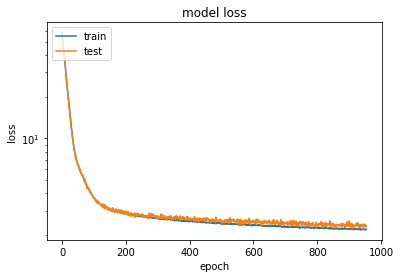

## MODEL SAVED ##


In [23]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = [df_conso.values[train_set,:]] + [c[train_set,:] for c in condarray]
output_cvae = df_conso.values[train_set,:]

new_cae.train(input_cvae, output_cvae, epochs= 2000, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop])

In [24]:
x_encoded = new_cae.encoder.predict(input_cvae)[0]

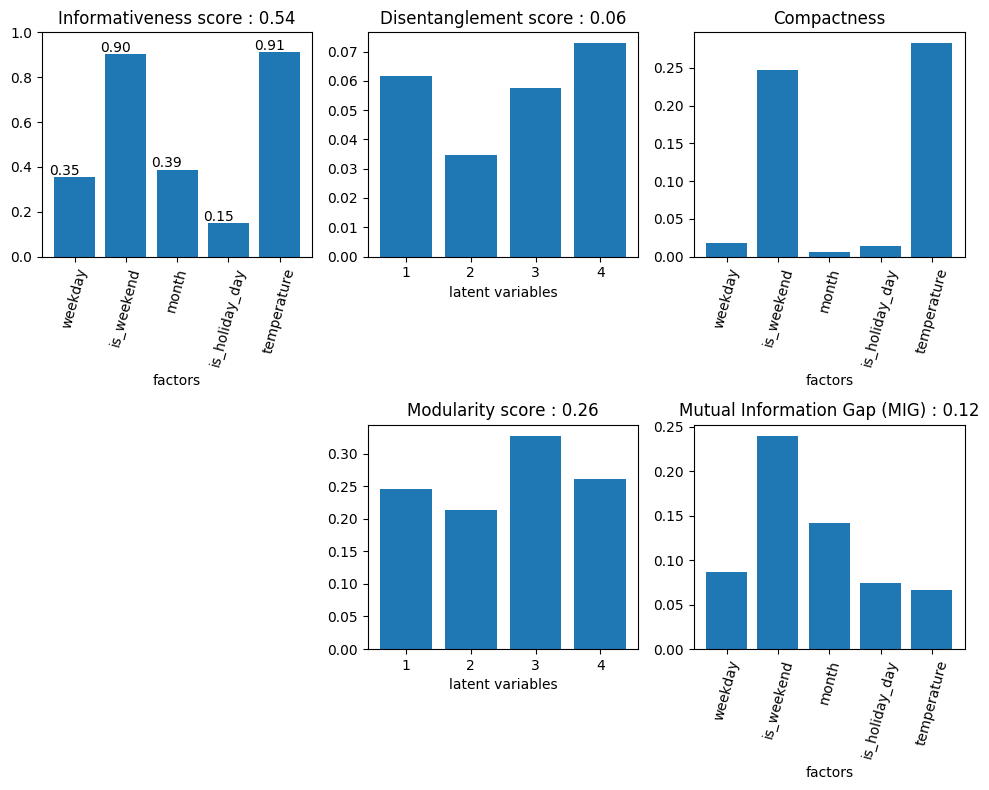

In [25]:
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [26]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

0.10804737821486583

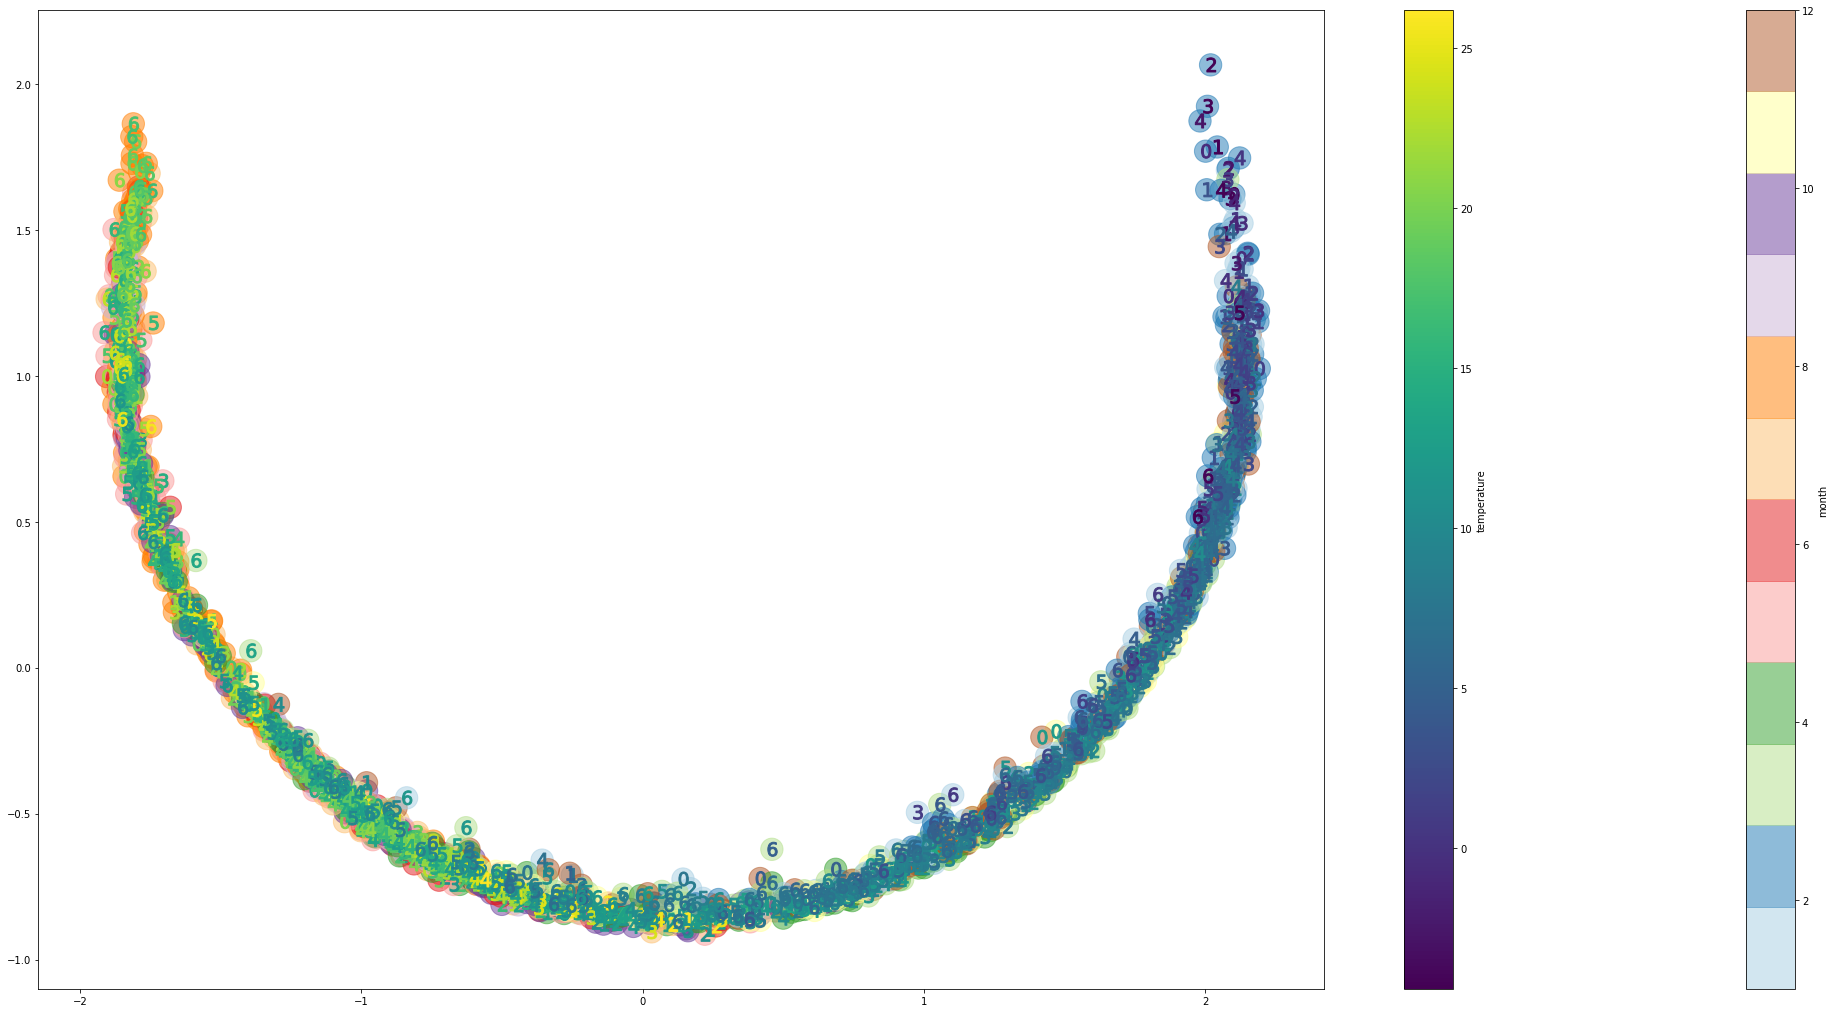

In [27]:
prez_2D(x_encoded, factorMatrix[train_set,:], temperatureMean[train_set])

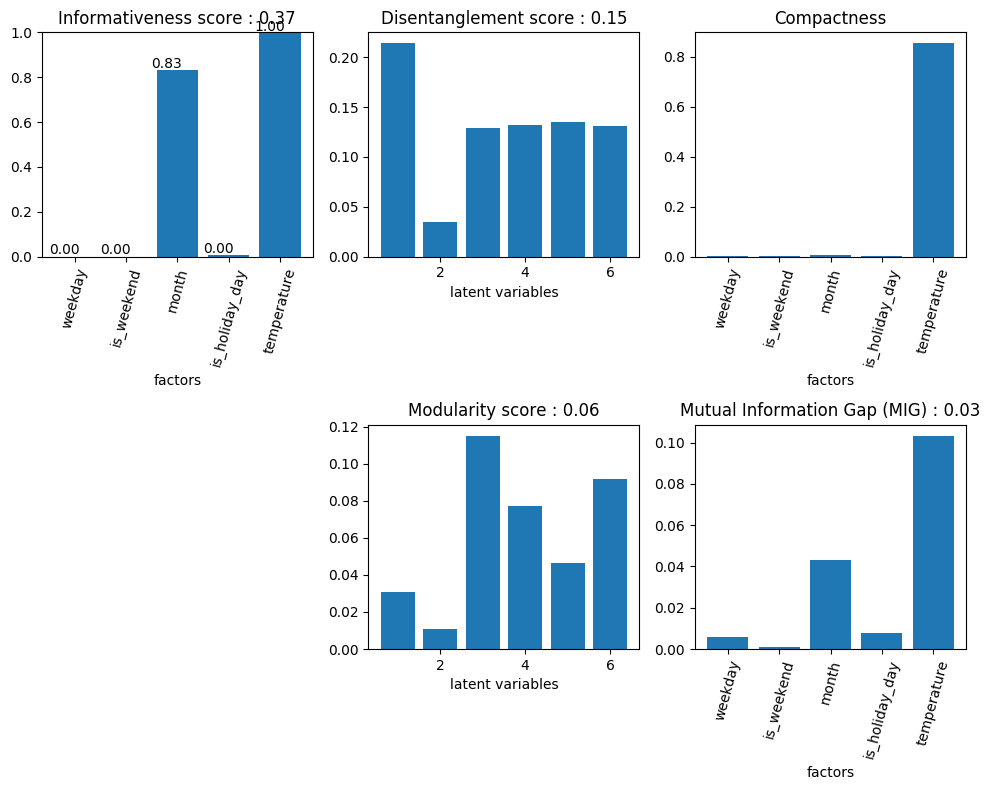

In [28]:
cond_emb = new_cae.cond_embedding.predict(input_cvae[1:])
model_eval, importanceMatrix =evaluate_latent_code(cond_emb, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, cond_emb.shape[1], factorDesc)

## Essai de la loss de mutual info

In [29]:
import callbacks
importlib.reload(callbacks)
from callbacks import *

In [30]:
def affinity_matrix(A):
    d0 = A.shape[0]
    d1 = A.shape[1]
    A_tiled1 = np.tile(A.reshape(d0,1,d1), [1,d0,1])
    A_tiled2 = np.tile(A.reshape(1,d0,d1), [d0,1,1])
    gram_A = np.sqrt(np.sum(np.square(A_tiled1 - A_tiled2 ), axis=-1))

    return gram_A

pca_test=PCA(6)
x_pca = pca_test.fit_transform(input_cvae[0])
y_mat = 1 * (affinity_matrix(x_pca) <=1.5)

0.9999999999999999


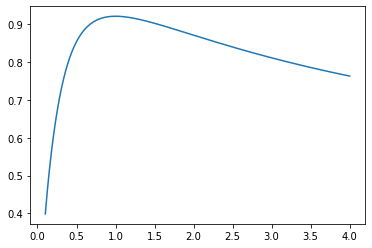

In [31]:
#Trouver le meilleur sigma
sigma = np.linspace(0.1,4, num=300, endpoint=True)

s_test=[]
for s in sigma:
    x_mat = numpy_make_Gram_matrix(input_cvae[0],s)
    
    s_test.append(np.trace(np.matmul(x_mat,y_mat.T))/(np.linalg.norm(x_mat, "fro")*np.linalg.norm(y_mat, "fro")))
sop=sigma[np.argmax(s_test)]
print(sop)
plt.plot(sigma, s_test)

In [32]:
sop = 0.9869565217391304

In [33]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,48,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur

In [34]:
#root git folder 
name_model="cvae_mutualinfo"
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
cond_dims  :=  []
cond_insert  :=  ['encoder', 'decoder']
with_embedding  :=  False
emb_dims  :=  []
reparametrize  :=  GaussianSampling
input_dims  :=  48
output_dims  :=  48
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [48, 48, 24, 12]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [12, 24, 48, 48]
decoder_type  :=  InceptionBlock_model
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [35]:
condtovae_dims

[48, 12]

In [36]:
len(vae_params.model_params.emb_dims)

0

In [37]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.cond_dims = condtovae_dims
vae_params.model_params.with_embedding = True
vae_params.model_params.emb_dims = [[36,22,10],[12,4],6]
vae_params.model_params.nb_encoder_ensemble = 1


loss_weights = {"recon_loss" : 1, "kl_loss" : 0.3, "info_loss":66}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None)
vae_loss.options["scale"] = sop
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5

In [38]:
mi_cvae=CVAE(vae_params)
mi_cvae.VAE_params.model_params.cond_insert

['encoder', 'decoder']

In [39]:
mi_cvae.build_model(vae_params)

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

In [40]:
epochs=500

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [42]:
               
histinfo = InformationHistory(scale=sop,alpha=1.01,dataset_train=input_cvae,
                              cond_insert = mi_cvae.VAE_params.model_params.cond_insert,
                              period=np.unique(np.logspace(0,4,endpoint=True, num=500, dtype=int)),
                              infotoeval=["XZ", "X(C+Z)", "CZ", "CEmb", "XX'"], printlogger=True)

## START TRAINING ##
Mutual informations for epoch 1 are XZ :  -10.352 ; X(C+Z) :  -38.089 ; CZ :  -3.200 ; CEmb :  -2.859 ; XX' :  -94.629
Mutual informations for epoch 2 are XZ :  -10.450 ; X(C+Z) :  -38.265 ; CZ :  -2.645 ; CEmb :  -2.670 ; XX' :  -92.198
Mutual informations for epoch 3 are XZ :  -10.861 ; X(C+Z) :  -38.536 ; CZ :  -2.127 ; CEmb :  -2.451 ; XX' :  -94.680
Mutual informations for epoch 4 are XZ :  -11.480 ; X(C+Z) :  -38.804 ; CZ :  -1.691 ; CEmb :  -2.290 ; XX' :  -92.364
Mutual informations for epoch 5 are XZ :  -12.490 ; X(C+Z) :  -38.903 ; CZ :  -1.562 ; CEmb :  -2.165 ; XX' :  -86.171
Mutual informations for epoch 6 are XZ :  -13.766 ; X(C+Z) :  -38.849 ; CZ :  -1.596 ; CEmb :  -1.964 ; XX' :  -90.033
Mutual informations for epoch 7 are XZ :  -14.928 ; X(C+Z) :  -38.640 ; CZ :  -1.692 ; CEmb :  -1.800 ; XX' :  -88.064
Mutual informations for epoch 8 are XZ :  -16.037 ; X(C+Z) :  -38.297 ; CZ :  -1.847 ; CEmb :  -1.645 ; XX' :  -86.579
Mutual informations for epo

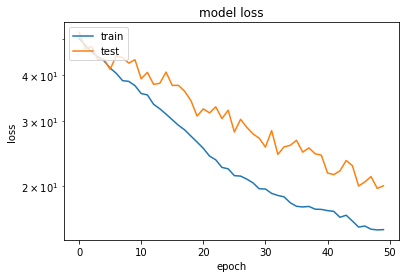

## MODEL SAVED ##


In [43]:
mi_cvae.train(input_cvae, output_cvae, epochs= 50, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

In [44]:
mi_cvae.maketrainable(modelpart=['encoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['decoder'], boolean=False)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=True)

Change trainable status of encoder layers
Change trainable status of decoder layers
Change trainable status of cond_embedding layers


In [45]:
for lay in mi_cvae.decoder.layers:
    print(lay.trainable)

False
False
False
True
False
False


In [46]:
for i in ['model','encoder', 'decoder', 'cond_embedding']:
    getattr(mi_cvae,i).summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',               
                                 (None, 4)]                       'cond_inputs_0[0][0]',       

## START TRAINING ##
Mutual informations for epoch 51 are XZ :  -19.221 ; X(C+Z) :  -19.280 ; CZ :  -7.190 ; CEmb :  4.870 ; XX' :  -9.238
Mutual informations for epoch 52 are XZ :  -18.887 ; X(C+Z) :  -18.758 ; CZ :  -7.396 ; CEmb :  4.865 ; XX' :  -10.107
Mutual informations for epoch 53 are XZ :  -18.390 ; X(C+Z) :  -17.941 ; CZ :  -7.727 ; CEmb :  4.855 ; XX' :  -10.030
Mutual informations for epoch 54 are XZ :  -17.829 ; X(C+Z) :  -17.204 ; CZ :  -7.997 ; CEmb :  4.870 ; XX' :  -9.583
Mutual informations for epoch 55 are XZ :  -17.089 ; X(C+Z) :  -16.261 ; CZ :  -8.324 ; CEmb :  4.875 ; XX' :  -9.982
Mutual informations for epoch 56 are XZ :  -16.394 ; X(C+Z) :  -15.346 ; CZ :  -8.651 ; CEmb :  4.871 ; XX' :  -8.213
Mutual informations for epoch 58 are XZ :  -14.898 ; X(C+Z) :  -13.151 ; CZ :  -9.359 ; CEmb :  4.905 ; XX' :  -3.748
Mutual informations for epoch 59 are XZ :  -14.292 ; X(C+Z) :  -12.191 ; CZ :  -9.616 ; CEmb :  4.954 ; XX' :  -5.029
Mutual informations for epoch 60 

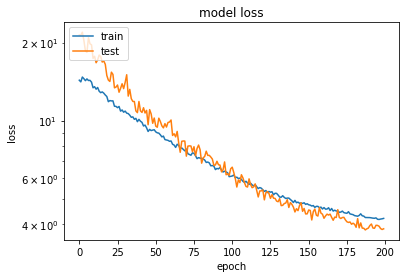

## MODEL SAVED ##


In [47]:
mi_cvae.train(input_cvae, output_cvae, epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[histinfo])

In [48]:
cond_emb = mi_cvae.cond_embedding.predict(input_cvae[1:])

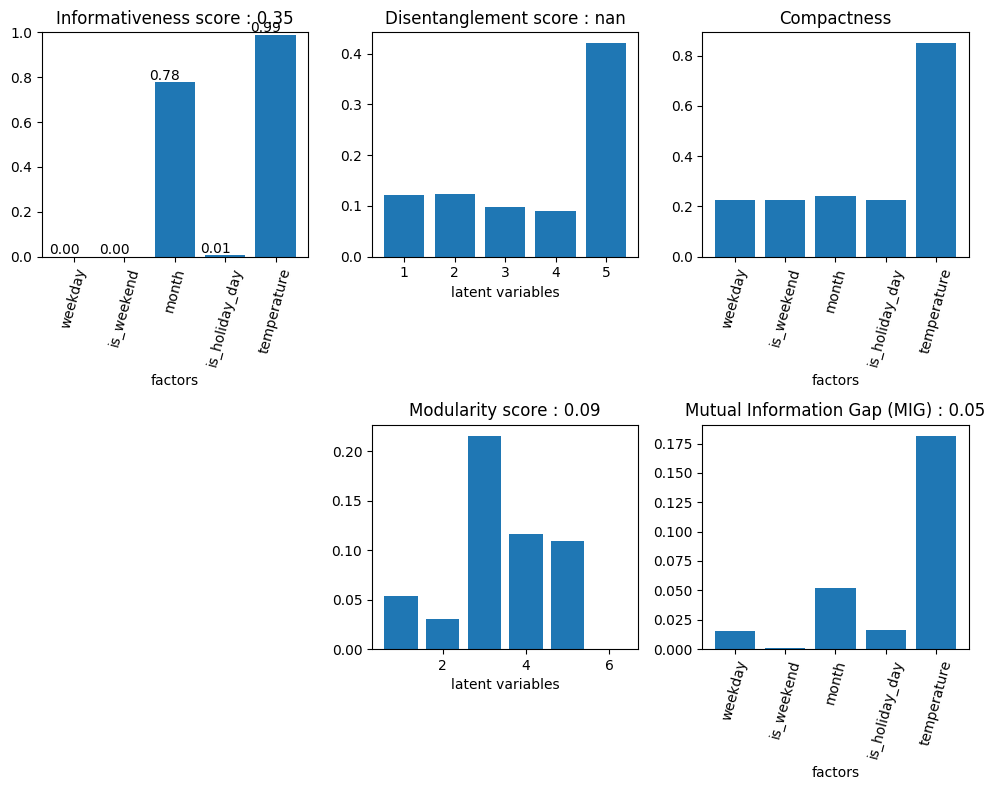

In [49]:
model_eval, importanceMatrix = evaluate_latent_code(cond_emb, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, cond_emb.shape[1], factorDesc)

In [50]:
mi_cvae.maketrainable(modelpart=['decoder'], boolean=True)
mi_cvae.maketrainable(modelpart=['cond_embedding'], boolean=False)
for lay in mi_cvae.decoder.get_layer("cond_emb").layers:
    print(lay.trainable)
for lay in mi_cvae.encoder.layers:
    print(lay.trainable)

Change trainable status of decoder layers
Change trainable status of cond_embedding layers
False
False
False
False
False
False
False
True
True
True
False
True
True
True


## START TRAINING ##
Mutual informations for epoch 253 are XZ :  -0.641 ; X(C+Z) :  36.310 ; CZ :  -66.342 ; CEmb :  -3.810 ; XX' :  53.431
Mutual informations for epoch 258 are XZ :  -3.721 ; X(C+Z) :  34.842 ; CZ :  -67.254 ; CEmb :  -3.810 ; XX' :  53.856
Mutual informations for epoch 263 are XZ :  -7.108 ; X(C+Z) :  32.834 ; CZ :  -68.146 ; CEmb :  -3.810 ; XX' :  54.461
Mutual informations for epoch 268 are XZ :  -9.276 ; X(C+Z) :  31.451 ; CZ :  -68.710 ; CEmb :  -3.810 ; XX' :  54.984
Mutual informations for epoch 273 are XZ :  -10.714 ; X(C+Z) :  30.027 ; CZ :  -68.728 ; CEmb :  -3.810 ; XX' :  53.841
Mutual informations for epoch 278 are XZ :  -11.326 ; X(C+Z) :  29.079 ; CZ :  -68.488 ; CEmb :  -3.810 ; XX' :  55.136
Mutual informations for epoch 283 are XZ :  -11.487 ; X(C+Z) :  27.751 ; CZ :  -67.637 ; CEmb :  -3.810 ; XX' :  54.486
Mutual informations for epoch 289 are XZ :  -11.401 ; X(C+Z) :  27.472 ; CZ :  -67.563 ; CEmb :  -3.810 ; XX' :  55.793
Mutual informations for

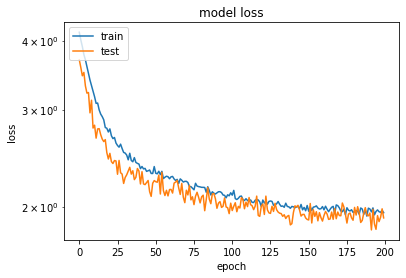

## MODEL SAVED ##


In [51]:
mi_cvae.train(input_cvae, output_cvae, epochs= 200, verbose=0,
              batch_size=batch_size, callbacks=[earl_stop, histinfo])

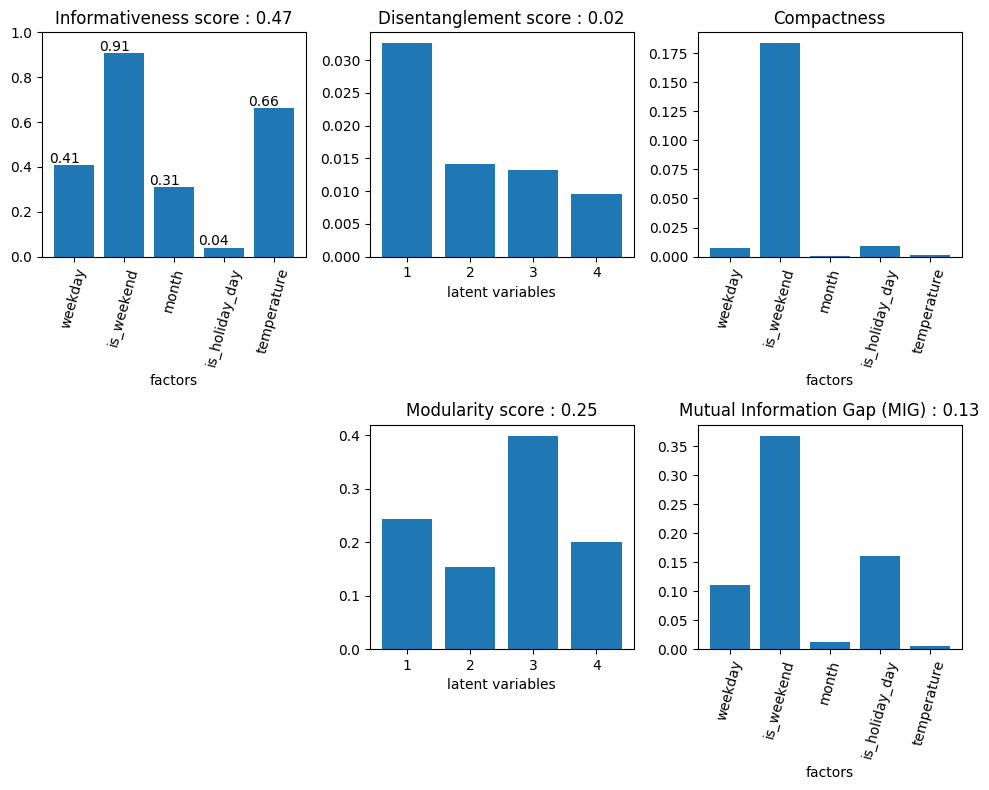

In [52]:
x_encoded = mi_cvae.encoder.predict(input_cvae)[0]
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [53]:
#mi_cvae.save()
loss_weights = {"recon_loss" : 1, "kl_loss" : 0.67, "info_loss" : 66, "mutualinfo_loss":1}

vae_loss = loss_class.VAELoss(loss_weights = loss_weights, custom_loss=None,
                             options={"prior_mu":0., "log_prior_sigma":0., "kl_annealing":0., "alpha":1.01, "scale":sop, "kappa":1.})
vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = 1e-5
vae_params.training_params.log_prior_sigma = [-2.,-1.,0.,1.]


In [54]:
mi_cvae.load_model(retrieve_model_architecture=True, training_params=vae_params.training_params)

Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_0 (InputLayer)     [(None, 48)]         0           []                               
                                                                                                  
 cond_inputs_1 (InputLayer)     [(None, 12)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          10230       ['x_inputs[0][0]',              

## START TRAINING ##


2022-03-03 11:39:09.599791: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x195ea360


Mutual informations for epoch 458 are XZ :  -19.890 ; X(C+Z) :  24.227 ; CZ :  -70.435 ; CEmb :  -3.555 ; XX' :  65.787
Mutual informations for epoch 467 are XZ :  -19.242 ; X(C+Z) :  23.747 ; CZ :  -70.024 ; CEmb :  -3.583 ; XX' :  66.574
Mutual informations for epoch 475 are XZ :  -18.849 ; X(C+Z) :  23.149 ; CZ :  -69.577 ; CEmb :  -3.708 ; XX' :  68.198
Mutual informations for epoch 484 are XZ :  -18.319 ; X(C+Z) :  22.931 ; CZ :  -69.303 ; CEmb :  -3.740 ; XX' :  67.801
Mutual informations for epoch 493 are XZ :  -18.009 ; X(C+Z) :  22.692 ; CZ :  -69.092 ; CEmb :  -3.738 ; XX' :  67.997
Mutual informations for epoch 502 are XZ :  -17.633 ; X(C+Z) :  22.479 ; CZ :  -68.840 ; CEmb :  -3.748 ; XX' :  69.548
Mutual informations for epoch 512 are XZ :  -17.372 ; X(C+Z) :  22.412 ; CZ :  -68.674 ; CEmb :  -3.718 ; XX' :  68.258
Mutual informations for epoch 521 are XZ :  -16.914 ; X(C+Z) :  21.925 ; CZ :  -68.114 ; CEmb :  -3.776 ; XX' :  68.862
Mutual informations for epoch 531 are XZ

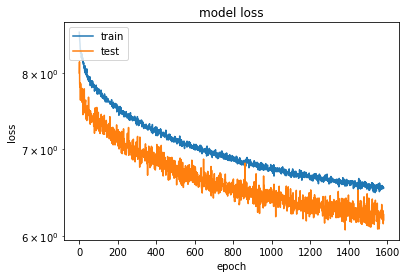

## MODEL SAVED ##


In [55]:
mi_cvae.train(input_cvae, output_cvae, epochs= 2000, verbose=0,
              batch_size=128, callbacks=[earl_stop, histinfo])

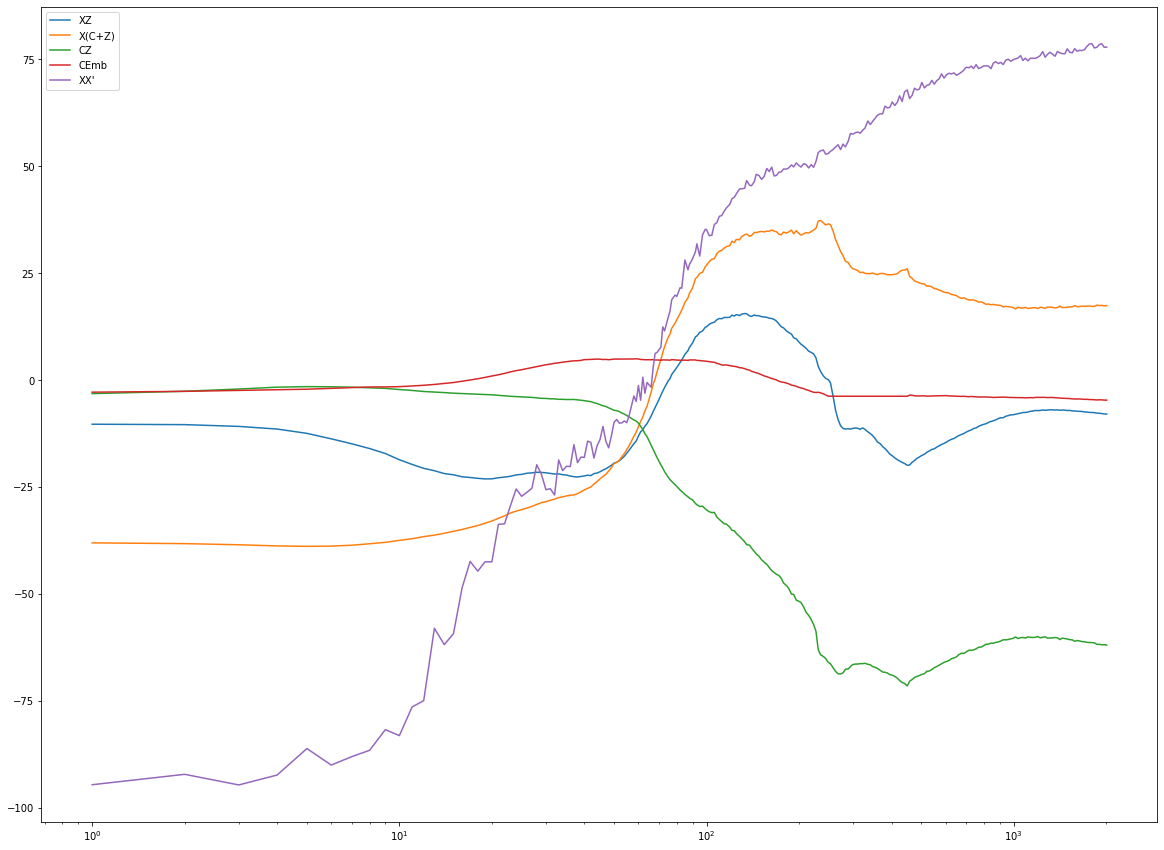

In [56]:
plt.figure(figsize=(20,15))
for key, list_val in histinfo.MI.items():
    plt.plot(histinfo.period[:len(list_val)], list_val, label=key)
plt.xscale("log")
plt.legend()

In [57]:
x_encoded = mi_cvae.encoder.predict(input_cvae)[0]

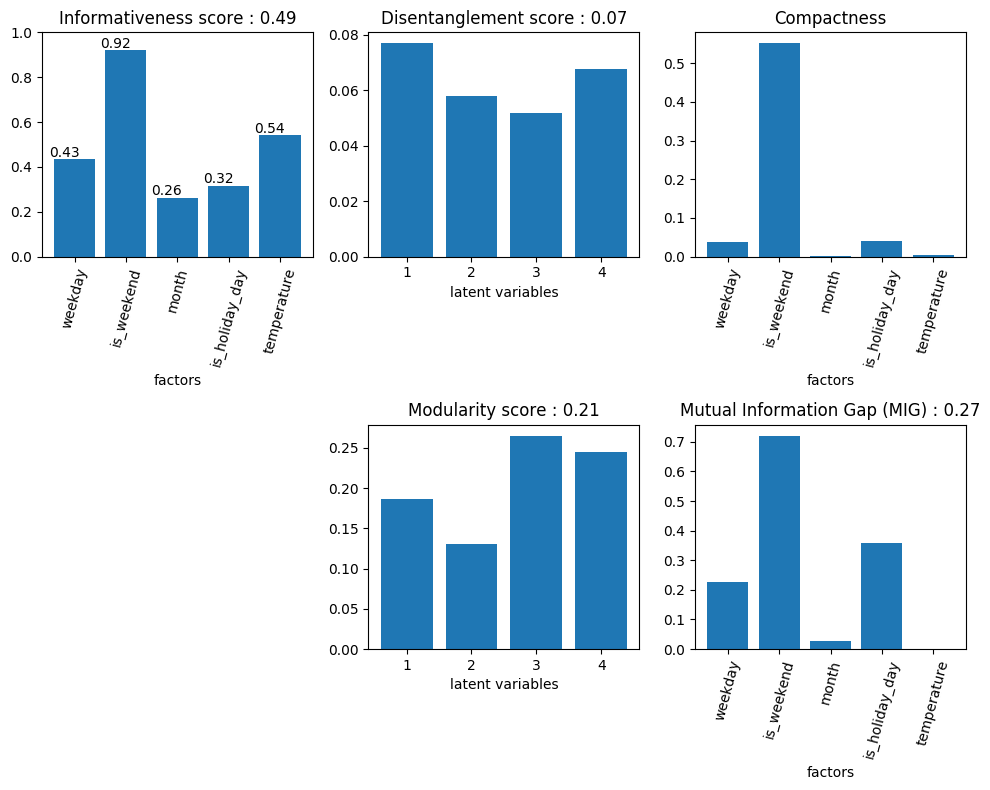

In [58]:
model_eval, importanceMatrix = evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
#normalize_information normalise le score avec le minimum obtenu avec une projection aléatoire
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [59]:
test_input_cvae = [df_conso.values[test_set,:]] + [c[test_set,:] for c in condarray]

x_hat = new_cae.model.predict(test_input_cvae)

np.mean(np.abs(x_hat - test_input_cvae[0]))

0.10495023754751569